<p style="text-align:center;"><img src="https://user-images.githubusercontent.com/80718476/127932180-d2dd10a1-779d-4124-8238-a04a21a9b8dc.png" alt="Logo"></p>

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

from PythonScripts import prepare, explore, modeling

# Predicting Programming Languages
### Authors: Linh Quach,  Robert Murphy,  Xavier Carter (August, 2021)

### Dataset
   Readmes from repositiories on Github

# Plan

# Project Goals
The goal will be to build a model that can predict what programming language a repository is, given the text of the README file.

# The Data Science Pipeline
- Acquire the data
- Prepare and clean data
- Explore
- Model & Evaluate
- Recommendations

# Executive Summary

- It was difficult to find one main feature that would predict the language of the readme contents due to many words being similar between languages.

- Through exploration we were able to find correlation between a list of unique words with unique combinations to be able predict programming language of the readme contents.

- All of our models were overfit to some degree with the exception of our KNN model.

- The models we created were a Decision tree, KNNeighbors, Logistic Regression, Random Forest, Linear SVC and Naive Bayes. The model we chose as our best model for the test dataset was the KNNeighbors model with a 83% accuracy rate for predicting the programming language of readme contents from Github.

- The K-Nearest Neighbors Model (83%) outperformed our baseline score of 27 % thus it has value.


-----

### Acquire

In [64]:
#utilizing json file created from acquire.py, using pandas read json to create a dataframe
df = pd.read_json('data2.json')

In [65]:
df.head()

,repo,language,readme_contents
0,IrisShaders/Iris,Java,![Iris: An open-source shaders mod compatible ...
1,returntocorp/semgrep,Java,"</br>\n<p align=""center"">\n <a href=""https:..."
2,CaffeineMC/sodium-fabric,Java,"<img src=""src/main/resources/assets/sodium/ico..."
3,keycloak/keycloak,Java,# Keycloak\n\nKeycloak is an Open Source Ident...
4,NationalSecurityAgency/ghidra,Java,"<img src=""Ghidra/Features/Base/src/main/resour..."


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             225 non-null    object
 1   language         225 non-null    object
 2   readme_contents  225 non-null    object
dtypes: object(3)
memory usage: 5.4+ KB


In [67]:
df.language.value_counts()

R             75
Java          50
Python        50
JavaScript    50
Name: language, dtype: int64

-----

#### Acquire Findings:

To Do's:

1) drop duplicates, drop null values.

2) lower case language and repo columns, and readme_contents as well.

3) drop non alpha-numeric values.

4) Drop words which are excessively long, appears there is combination of words.

-----

### Prepare

In [68]:
#utilizing prepare function which will retrun a df containing original columns and columns which have been normalized, lemmatized, tokenized and had stopwords removed or added.
df = prepare.prep_repo_data(df)

In [69]:
df.head()

,repo_name,language,readme_contents,repo_name_cleaned,language_cleaned,readme_contents_cleaned
0,IrisShaders/Iris,Java,![Iris: An open-source shaders mod compatible ...,irisshadersiris,java,iris opensource shaders mod compatible optifin...
1,returntocorp/semgrep,Java,"</br>\n<p align=""center"">\n <a href=""https:...",returntocorpsemgrep,java,br p aligncenter hrefhttpssemgrepdevimg srchtt...
2,CaffeineMC/sodium-fabric,Java,"<img src=""src/main/resources/assets/sodium/ico...",caffeinemcsodiumfabric,java,img srcsrcmainresourcesassetssodiumiconpng wid...
3,keycloak/keycloak,Java,# Keycloak\n\nKeycloak is an Open Source Ident...,keycloakkeycloak,java,keycloak keycloak open source identity access ...
4,NationalSecurityAgency/ghidra,Java,"<img src=""Ghidra/Features/Base/src/main/resour...",nationalsecurityagencyghidra,java,img srcghidrafeaturesbasesrcmainresourcesimage...


#### Feauture Engineering

In [70]:
#After brief examination, we realized in order to reduce noise
df['readme_contents_cleaned'] = df['readme_contents_cleaned'].str.findall('\w{1,18}').str.join(' ')

In [71]:
#Message Length and wordcounts for each read me
df['message_length'] = df.readme_contents_cleaned.apply(len)
df['word_count'] =  df.readme_contents_cleaned.str.split().apply(len)

#### Split For Explore

In [72]:
train, validate, test = prepare.lang_split(df)
train.shape, validate.shape, test.shape

((97, 8), (42, 8), (35, 8))

The following was done to prep the data.


- Removed accented characters in 3 steps as listed below:
1. unicodedata.normalize removes any inconsistencies in unicode character encoding.
2. .encode to convert the resulting string to the ASCII character set. We'll ignore any errors in conversion, meaning we'll drop anything that isn't an ASCII character.
3. .decode to turn the resulting bytes object back into a string.


- renamed columns
- dropped duplicates
- Tokenized Data
- Lemmatized Data
- removed a list of stop words

-----

#### Prepare Takeways:
- Data was fairly messy and required us to take many steps to be able to change the readme contents into a state in which we can use it to create features, perform exploration, and to be able to feed it by our model.
- Feature engineered: Message length and word count for each readme content.
- columns renamed for readability
- After the cleaning was complete, we split the dataset to transition the data into train, validate, & test.

-----

### Explore

In [73]:
train.language.value_counts()

Python        26
JavaScript    26
Java          24
R             21
Name: language, dtype: int64

<AxesSubplot:xlabel='language', ylabel='Count'>

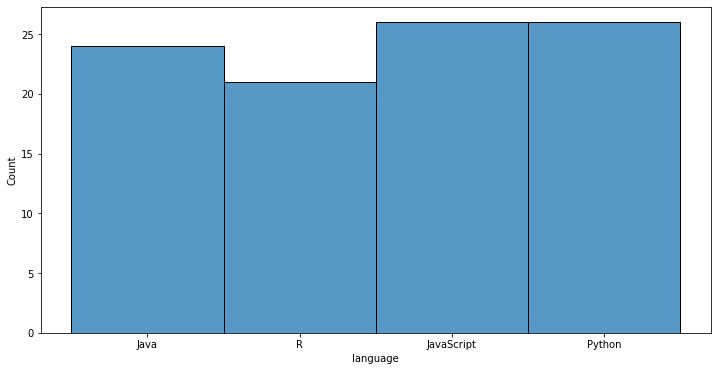

In [74]:
sns.histplot(train, x=train.language)

Takeway: There is more Javascript, Python, and Java in our dataset than R.

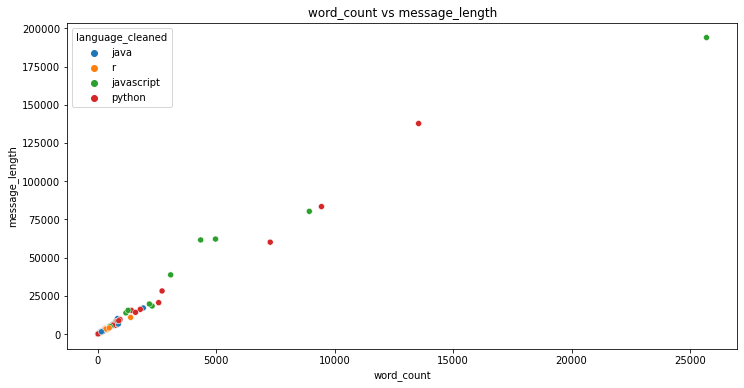

In [75]:
explore.show_scatter_plot(train, 'word_count', 'message_length', 'language_cleaned')

##### Takeaways
- Word count and message length may play a role in the programming language used

In [76]:
# splitting the readmes into strings
java_read = ' '.join(train[train.language_cleaned == 'java'].readme_contents_cleaned)
python_read = ' '.join(train[train.language_cleaned == 'python'].readme_contents_cleaned)
r_read = ' '.join(train[train.language_cleaned == 'r'].readme_contents_cleaned)
javascript_read = ' '.join(train[train.language_cleaned == 'javascript'].readme_contents_cleaned)
all_content = ' '.join(train.readme_contents_cleaned)

In [77]:
#Counts as percent ratios
explore.show_counts_and_ratios(train, "language_cleaned")

,n,percent
javascript,26,0.268041
python,26,0.268041
java,24,0.247423
r,21,0.216495


In [78]:
#creating word frequencies
java_freq = pd.Series(java_read.split()).value_counts()
python_freq = pd.Series(python_read.split()).value_counts()
r_freq= pd.Series(r_read.split()).value_counts()
javascript_freq= pd.Series(javascript_read.split()).value_counts()
all_freq = pd.Series(all_content.split()).value_counts()

In [79]:
#Creating word counts table
word_table = (pd.concat([java_freq, python_freq, r_freq, javascript_freq, all_freq], axis=1, sort=True)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
#naming the columns
word_table.columns = ['java', 'python', 'r', 'javascript', 'All']

In [80]:
#Creating list of words
java_words = re.sub(r'[^\w\s]', '', java_read).split()
r_words = re.sub(r'[^\w\s]', '', r_read).split()
python_words = re.sub(r'[^\w\s]', '', python_read).split()
javascript_words = re.sub(r'[^\w\s]', '', javascript_read).split()
all_content_words = re.sub(r'[^\w\s]', '', all_content).split()

### Frequency Graphs
- Top 20 words most common words used and what language is using them

#### Java

Text(0.5, 1.0, 'Top 20 most Frequent words by Java')

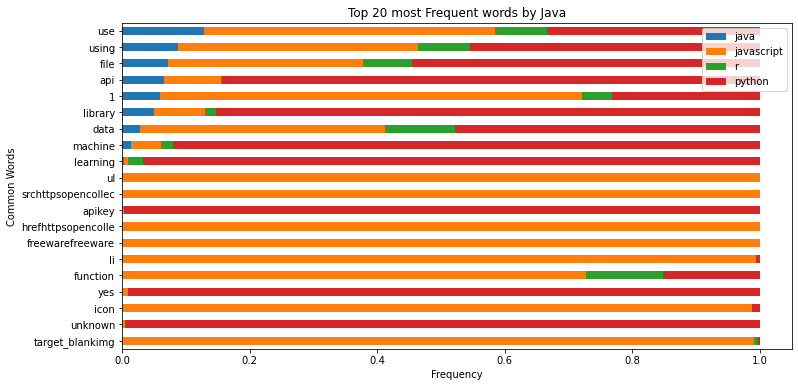

In [81]:
explore.show_distributions(word_table, orderby='java')
plt.xlabel('Frequency')
plt.ylabel('Common Words')
plt.title ('Top 20 most Frequent words by Java')

Takeway: Here we can see some of the top common words for Java are use, using, file and api.

#### Javascript

Text(0.5, 1.0, 'Top 20 most Frequent words by Javascript')

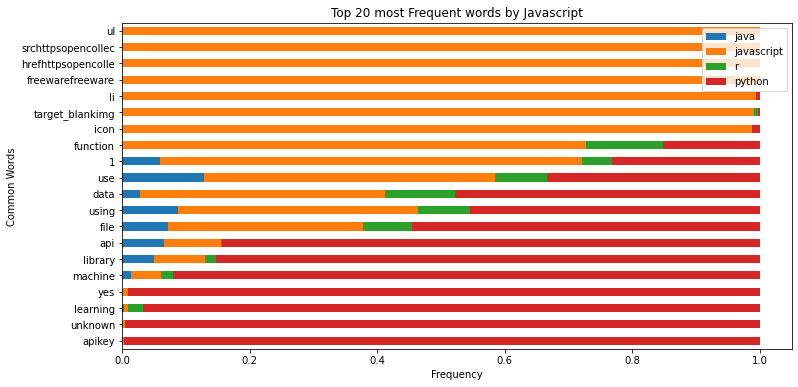

In [82]:
explore.show_distributions(word_table, orderby='javascript')
plt.xlabel('Frequency')
plt.ylabel('Common Words')
plt.title ('Top 20 most Frequent words by Javascript')

Takeway: Here we can see some of the top common words for Javascript are ul, srchttpsopencollec, hrefhttsopencolle freewarefreeware, and li.

#### R

Text(0.5, 1.0, 'Top 20 most Frequent words by R')

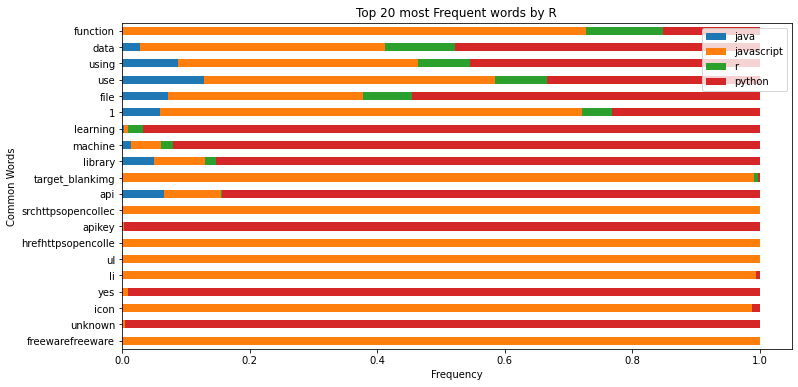

In [83]:
explore.show_distributions(word_table, orderby='r')
plt.xlabel('Frequency')
plt.ylabel('Common Words')
plt.title ('Top 20 most Frequent words by R')

Takeway: Here we can see some of the top common words for R are function, data, use, and file.

#### Python

Text(0.5, 1.0, 'Top 20 most Frequent words by Python')

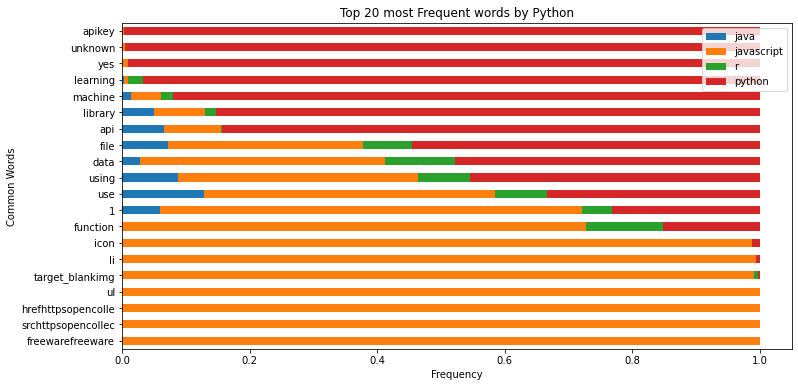

In [84]:
explore.show_distributions(word_table, orderby='python')
plt.xlabel('Frequency')
plt.ylabel('Common Words')
plt.title ('Top 20 most Frequent words by Python')

Takeway: Here we can see some of the top common words for Python are apikey, unknown, yes, and learning.

### WordClouds

#### Java 

-------------------
java
-------------------


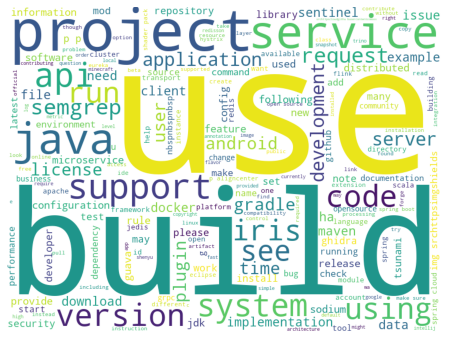

In [85]:
explore.df_to_wordcloud(train, 'java')

Takeway: The words stand out in this Java wordcloud are build, use, and project.

-------------------
javascript
-------------------


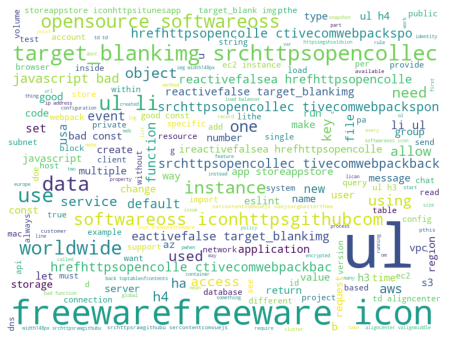

In [86]:
explore.df_to_wordcloud(train, 'javascript')

Takeway: The words stand out in this Javascript wordcloud are freewarefreewware, ul, and icon.

-------------------
r
-------------------


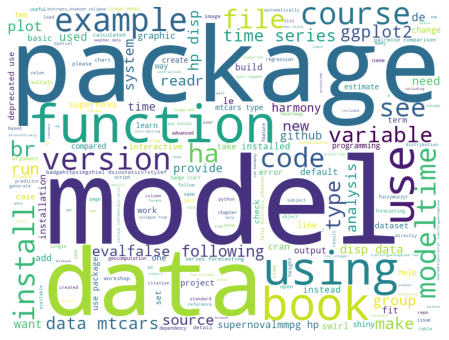

In [87]:
explore.df_to_wordcloud(train, 'r')

Takeway: The words stand out in this R wordcloud are package, data, book, model, function, and example.

-------------------
python
-------------------


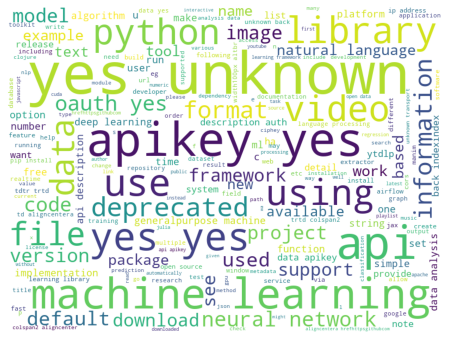

In [88]:
explore.df_to_wordcloud(train, 'python')

Takeway: The words stand out in this Python wordcloud are apikey, yes, unknown, machine learning, library, and python.

##### Bigrams

In [89]:
#top 20 bigrams for each language
top_20_bigrams_java = pd.Series(nltk.ngrams(java_read.split(), 2)).value_counts().head(20)
top_20_bigrams_javascript = pd.Series(nltk.ngrams(javascript_read.split(), 2)).value_counts().head(20)
top_20_bigrams_r = pd.Series(nltk.ngrams(r_read.split(), 2)).value_counts().head(20)
top_20_bigrams_python = pd.Series(nltk.ngrams(python_read.split(), 2)).value_counts().head(20)

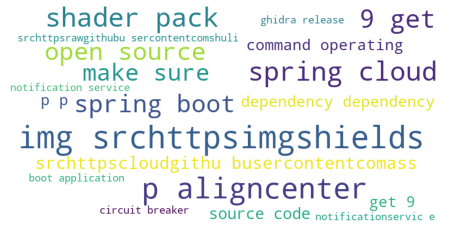

In [90]:
explore.bigrams_wordclouds(top_20_bigrams_java)

Takeway: The words that stand out in this Java bigram are p/aligncenter, spring/cloud, and img/srchttpsimgshields.

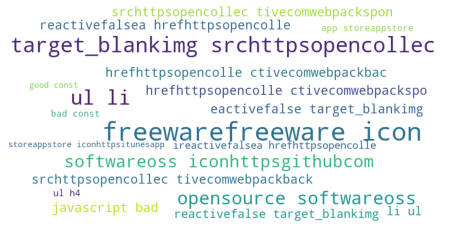

In [91]:
explore.bigrams_wordclouds(top_20_bigrams_javascript)

Takeway: The words that stand out in this Javascript bigram are target/blankimg, freewarefreeware/icon, and opensource/softwareoss.

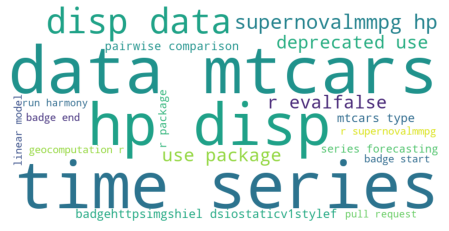

In [92]:
explore.bigrams_wordclouds(top_20_bigrams_r)

Takeway: The words that stand out in this R bigram are time/series, disp/data, and data/mtcars.

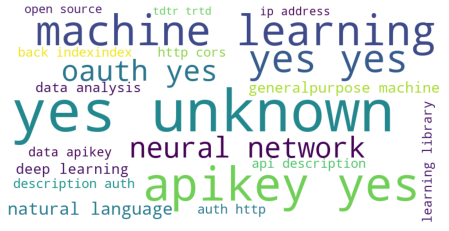

In [93]:
explore.bigrams_wordclouds(top_20_bigrams_python)

Takeway: The words that stand out in this Python bigram are machine/learning, apikey/yes, yes/unknown, and neural/network.

Trigrams

In [94]:
#top 20 trigrams for each language
top_20_trigrams_java = pd.Series(nltk.ngrams(java_read.split(), 3)).value_counts().head(20)
top_20_trigrams_javascript = pd.Series(nltk.ngrams(javascript_read.split(), 3)).value_counts().head(20)
top_20_trigrams_r = pd.Series(nltk.ngrams(r_read.split(), 3)).value_counts().head(20)
top_20_trigrams_python = pd.Series(nltk.ngrams(python_read.split(), 3)).value_counts().head(20)
                                                                                            

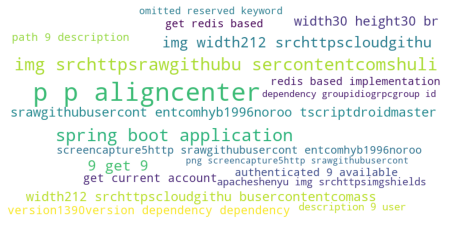

In [95]:
explore.trigrams_wordclouds(top_20_trigrams_java)

Takeway: The words that stand out in this Java Trigram are spring boot application, p p aligncentr, and img srchttpsrawgithubu sercontentcomshuli.

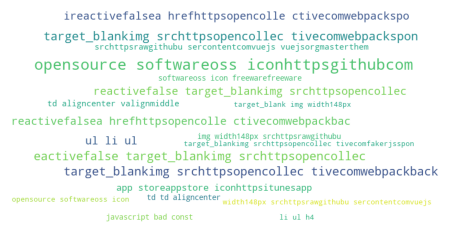

In [96]:
explore.trigrams_wordclouds(top_20_trigrams_javascript)

Takeway: The words that stand out in this Javascript Trigram are opensource softwareosss iconhttpsgithubcom, target_blankimg srchttpsopencollec tivecomwebpackspon, and ireactivefalsea hrefhttpsopencolle ctivecomwebpackspo.

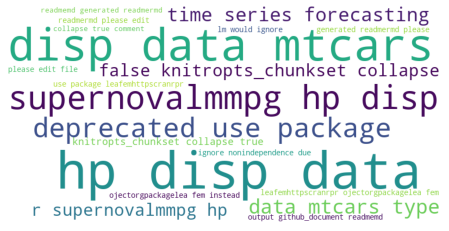

In [97]:
explore.trigrams_wordclouds(top_20_trigrams_r)

Takeway: The words that stand out in this R Trigram are disp data mtcars, hp disp data, and supernovalmmpg hp disp.

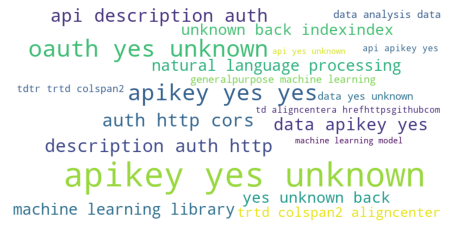

In [98]:
explore.trigrams_wordclouds(top_20_trigrams_python)

Takeway: The words that stand out in this Java Trigram are data apikey yes, oauth yes unknown, and apikey yes unknown

In [99]:
#most common words used
common = []
for i in all_content_words:
    if i in java_read:
        if i in javascript_read:
            if i in r_read:
                if i in python_read:
                    common.append(i)
common = ' '.join(common)


-------------------
Common Words
-------------------


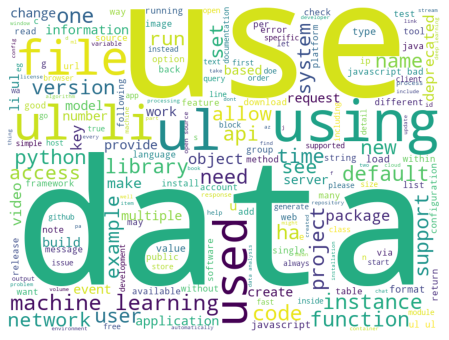

In [100]:
explore.word_cloud(common, 'Common Words')

Takeway: The most common words in all the languages are included in this wordcloud. The words that stand out in this wordcloud are data, use, using, used, ul, li, and file.

-----

#### Explore Takeways:
- From exploring all of the common words in each language along with all the languages combined we see we can add additional stop words to our model such as data and use.
- Word count and message length may play a role in the programming language used.

-----

### Modeling 
- For modeling , we will split our original dataframe into train validate and test

In [13]:
tfidf = TfidfVectorizer(stop_words = ['data','use'])
X = tfidfs = tfidf.fit_transform(df.readme_contents_cleaned)
y = df.language_cleaned

In [14]:
X_train, X_validate, y_train, y_validate, X_test, y_test = modeling.xy_split(X, y)

### Baseline 

In [15]:
modeling.get_baseline(train)

26.80400%


### Decision Tree

In [16]:
tree = DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 7)
modeling.train_validate_results(tree, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 74.22680 %  | Validate model accuracy: 66.66667 % 
Train model Recall: 73.95833 %    | Validate model Recall: 65.36616 %
Train model Precision: 80.40675 % | Validate model Precision: 80.86957 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                java  javascript     python          r  accuracy  macro avg  \
precision   0.904762    0.547619   0.888889   0.875000  0.742268   0.804067   
recall      0.791667    0.884615   0.615385   0.666667  0.742268   0.739583   
f1-score    0.844444    0.676471   0.727273   0.756757  0.742268   0.751236   
support    24.000000   26.000000  26.000000  21.000000  0.742268  97.000000   

           weighted avg  
precision      0.798335  
recall         0.742268  
f1-score       0.749030  
support       97.000000  
------Validate Classification report-----
                java  javascript     python         r  accuracy  macr

### KNN

In [25]:
knn = KNeighborsClassifier(n_neighbors=(9))
modeling.train_validate_results(knn, X_train, y_train, X_validate, y_validate, details=True)

Train model Accuracy: 79.38144 %  | Validate model accuracy: 78.57143 % 
Train model Recall: 80.23123 %    | Validate model Recall: 79.10354 %
Train model Precision: 81.66043 % | Validate model Precision: 82.29167 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                java  javascript     python          r  accuracy  macro avg  \
precision   0.718750    0.823529   0.724138   1.000000  0.793814   0.816604   
recall      0.958333    0.538462   0.807692   0.904762  0.793814   0.802312   
f1-score    0.821429    0.651163   0.763636   0.950000  0.793814   0.796557   
support    24.000000   26.000000  26.000000  21.000000  0.793814  97.000000   

           weighted avg  
precision      0.809169  
recall         0.793814  
f1-score       0.788135  
support       97.000000  
------Validate Classification report-----
                java  javascript  python         r  accuracy  macro a

### Logistic Regression

In [26]:
lm = LogisticRegression(C=1).fit(X_train, y_train)
modeling.train_validate_results(lm, X_train, y_train, X_validate, y_validate, details=True )

Train model Accuracy: 100.00000 %  | Validate model accuracy: 71.42857 % 
Train model Recall: 100.00000 %    | Validate model Recall: 69.67172 %
Train model Precision: 100.00000 % | Validate model Precision: 78.72024 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
           java  javascript  python     r  accuracy  macro avg  weighted avg
precision   1.0         1.0     1.0   1.0       1.0        1.0           1.0
recall      1.0         1.0     1.0   1.0       1.0        1.0           1.0
f1-score    1.0         1.0     1.0   1.0       1.0        1.0           1.0
support    24.0        26.0    26.0  21.0       1.0       97.0          97.0
------Validate Classification report-----
                java  javascript     python         r  accuracy  macro avg  \
precision   0.857143    0.625000   0.666667  1.000000  0.714286   0.787202   
recall      0.600000    0.909091   0.833333  0.4444

### Random Forest

In [27]:
rf  = RandomForestClassifier(random_state=123, max_depth=3, min_samples_leaf=7)
modeling.train_validate_results(rf, X_train, y_train, X_validate, y_validate, details=True )

Train model Accuracy: 76.28866 %  | Validate model accuracy: 38.09524 % 
Train model Recall: 74.50778 %    | Validate model Recall: 35.39141 %
Train model Precision: 83.67063 % | Validate model Precision: 55.76923 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
                java  javascript     python          r  accuracy  macro avg  \
precision   0.950000    0.777778   0.619048   1.000000  0.762887   0.836706   
recall      0.791667    0.807692   1.000000   0.380952  0.762887   0.745078   
f1-score    0.863636    0.792453   0.764706   0.551724  0.762887   0.743130   
support    24.000000   26.000000  26.000000  21.000000  0.762887  97.000000   

           weighted avg  
precision      0.825953  
recall         0.762887  
f1-score       0.750511  
support       97.000000  
------Validate Classification report-----
                java  javascript     python         r  accuracy  macr

### Linear SVC

In [28]:
svc = LinearSVC(C=1.5)
modeling.train_validate_results(svc, X_train, y_train, X_validate, y_validate, details=True )

Train model Accuracy: 100.00000 %  | Validate model accuracy: 83.33333 % 
Train model Recall: 100.00000 %    | Validate model Recall: 82.72727 %
Train model Precision: 100.00000 % | Validate model Precision: 86.19048 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
           java  javascript  python     r  accuracy  macro avg  weighted avg
precision   1.0         1.0     1.0   1.0       1.0        1.0           1.0
recall      1.0         1.0     1.0   1.0       1.0        1.0           1.0
f1-score    1.0         1.0     1.0   1.0       1.0        1.0           1.0
support    24.0        26.0    26.0  21.0       1.0       97.0          97.0
------Validate Classification report-----
           java  javascript     python         r  accuracy  macro avg  \
precision   0.9    0.714286   0.833333  1.000000  0.833333   0.861905   
recall      0.9    0.909091   0.833333  0.666667  0.833333   

### Naive Bayes

In [29]:
nb = MultinomialNB(alpha=.05)
modeling.train_validate_results(nb, X_train, y_train, X_validate, y_validate, details=True )

Train model Accuracy: 100.00000 %  | Validate model accuracy: 73.80952 % 
Train model Recall: 100.00000 %    | Validate model Recall: 73.54798 %
Train model Precision: 100.00000 % | Validate model Precision: 77.66484 %
------------------------------------------------------------------------
---------- More Details ------------
-----Train Classification report----
           java  javascript  python     r  accuracy  macro avg  weighted avg
precision   1.0         1.0     1.0   1.0       1.0        1.0           1.0
recall      1.0         1.0     1.0   1.0       1.0        1.0           1.0
f1-score    1.0         1.0     1.0   1.0       1.0        1.0           1.0
support    24.0        26.0    26.0  21.0       1.0       97.0          97.0
------Validate Classification report-----
                java  javascript     python         r  accuracy  macro avg  \
precision   0.714286    0.700000   0.692308  1.000000  0.738095   0.776648   
recall      1.000000    0.636364   0.750000  0.5555

## Best Model on Test 

In [32]:
modeling.test_results(knn, X_test, y_test, X_train, y_train, details=True)

Test model Accuracy: 82.85714 %
Test model Recall: 83.19444 % 
Test model Precision: 84.65909 %
---------- More Details ------------
-----Test Classification report----
               java  javascript    python      r  accuracy  macro avg  \
precision  0.636364    1.000000  0.875000  0.875  0.828571   0.846591   
recall     0.875000    0.800000  0.777778  0.875  0.828571   0.831944   
f1-score   0.736842    0.888889  0.823529  0.875  0.828571   0.831065   
support    8.000000   10.000000  9.000000  8.000  0.828571  35.000000   

           weighted avg  
precision      0.856169  
recall         0.828571  
f1-score       0.834154  
support       35.000000  
-----Test Confusion Matrix------
            Java  Javascript  R  Python
Java           7           1  2       1
Javascript     0           8  0       0
R              0           1  7       0
Python         1           0  0       7


# Function to Predict Program Language based on Readme Contents

In [ ]:
def xy_split(X, y):
    '''
    This function take in the readme data acquired
    performs a split and stratifies language_cleaned column.
    Returns train, validate, and test dfs.
    '''
    X_train_validate, X_test, y_train_validate, y_test = train_test_split(X, y, test_size=.2, 
                                                                          random_state=254, 
                                                                          stratify = y)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train_validate, y_train_validate, test_size=.3,random_state=254,stratify= y_train_validate)
    return X_train, X_validate, y_train, y_validate, X_test, y_test


In [ ]:
def predict_readme_contents(string, df):
    
    vector = TfidfVectorizer(stop_words = ['data','use'])
    X = vector.fit(df.readme_contents_cleaned)
    X = vector.transform(df.readme_contents_cleaned)
    y = df.language_cleaned
    
    X_train, X_validate, y_train, y_validate, X_test, y_test = xy_split(X, y)
    
    string = prepare.basic_clean(string)
    string = prepare.tokenize(string)
    string = prepare.lemmatize(string)
    string = prepare.remove_stopwords(string, exclude_words=['data','use'])
   
    dicto = {'c':string}
    string = pd.Series(dicto)
    answer = vector.transform(dicto)
    
    knn = KNeighborsClassifier(n_neighbors=(9))
    knn.fit(X_train, y_train)
    result = knn.predict(answer)
    
    return result
    

-----

#### Model Takeways:
- All models beat the baseline but many of our models were overfit: 
    - Decision Tree had a high accuracy score but slightly overfit
    - Logistic Regression, Random Forest, Linear SVC, and Naive Bayes models all had high accuracy scores but were very overfit to our train dataset.
    - KNNeighbors Model had a high accuracy score and was not overfit.
- The KNNeighbors performed the best with a test score of 83%.
- The KNNeighbors outperformed baseline by 56%.
- Our model performed better than the baseline thus it has value.

-----

# Conclusion:
- Through this NLP project we came away with the following key findings:

    - The reduction of noise by removing stop words significantly increased the accuracy score of our models.
    - Our model performed with 83% accuracy when predicting the programming language of readmes based on their content.
    - We created a function to predict the programming language based on the README contents and the function consistently predicted Javascript. This indicates our dataset is unbalanced. With more time we would either reduced the data of the most common languages (Javascript, Java, and Python) to create a more even dataset or we would gather more data for the less common language (R) to create a more even dataset.


<b>Recommendations & next steps:</b>

- The KNNeighbors outperformed baseline by <b>56%</b> thus it has value and is the recommended model to be used.

- We would recommend adding more readmes from github to the dataset to further prevent overfitting of our models and to possibly increase accuracy.

- If we had more time:

  - We would have worked more with hyperparameters in our models to improve the models
  - We would have worked more with hyperparameters in our vectorizers 
  - We would further explore the data to create more features


-----